# 2nd CMI-PB Prediction Challenge
### Team Advisor: Barry Grant, Jason Hsiao
### Team member: Peng Cheng, Javier Garcia, Brian Qian, Weikang Guan

### Peng's version

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

## Step 1: Data Cleaning

In [2]:
## Load data into dataframes
df_2020_titer = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_plasma_ab_titer.tsv", sep='\t')
df_2020_specimen = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_specimen.tsv", sep='\t')
df_2020_subject = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_subject.tsv", sep='\t')
df_2021_titer = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_plasma_ab_titer.tsv", sep='\t')
df_2021_specimen = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_specimen.tsv", sep='\t')
df_2021_subject = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_subject.tsv", sep='\t')
df_2022_titer = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_plasma_ab_titer.tsv", sep='\t')
df_2022_specimen = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_specimen.tsv", sep='\t')
df_2022_subject = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_subject.tsv", sep='\t')

In [3]:
def clean_df_subject(df):
    df.dropna(inplace=True)
    
    ## Get age column
    df['year_of_birth'] = pd.to_numeric(df['year_of_birth'].str[:4])
    df['date_of_boost'] = pd.to_numeric(df['date_of_boost'].str[:4])
    df['Age'] = df['date_of_boost'] - df['year_of_birth']
    df.drop(['year_of_birth','date_of_boost','dataset'], axis=1, inplace=True)
    
    ##use OneHotEncoder for infancy_vac', 'biological_sex', 'ethnicity' and 'race' columns
    columns_to_encode = ['infancy_vac', 'biological_sex', 'ethnicity', 'race']
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    df_encoded = pd.DataFrame(encoder.fit_transform(df[columns_to_encode]), columns=encoder.get_feature_names_out(columns_to_encode))
    df = pd.concat([df, df_encoded], axis=1)
    df.drop(columns=columns_to_encode, inplace=True)
    return df

def clean_df_specimen(df):
    df.dropna(inplace=True)

    # extract row with 0 or 14 in the "planned_day_relative_to_boost" column
    df = df[(df['planned_day_relative_to_boost'] == 0) | (df['planned_day_relative_to_boost'] == 14)]
    df = df[['specimen_id', 'subject_id', 'actual_day_relative_to_boost', 'planned_day_relative_to_boost']]
    
    #remove subjects that have either only 0 or only 14 in the "planned_day_relative_to_boost" column,
    df = df.groupby('subject_id').filter(lambda x: (0 in x['planned_day_relative_to_boost'].values) and\
                                         (14 in x['planned_day_relative_to_boost'].values))
    return df

def clean_df_titer(df):
    df.dropna(inplace=True)
    
    # extract row with IgG in the "isotype" column and PT in the "antigen" column
    df = df[(df['isotype'] == 'IgG') & (df['antigen'] == 'PT')]
    df = df[['specimen_id', 'MFI_normalised']]
    return df

In [4]:
def merge_df_for_train(df_subject,df_specimen,df_titer):
    df = pd.merge(pd.merge(clean_df_titer(df_titer), 
                           clean_df_specimen(df_specimen), on='specimen_id'), 
                  clean_df_subject(df_subject), on='subject_id')
    return df

def clean_merged_df_for_train(df):
    #create the new column "IgG-PT-D0-titer"
    df['IgG-PT-D0-titer'] = df.apply(lambda row: df[(df['subject_id'] == row['subject_id']) &\
                                                (df['planned_day_relative_to_boost'] == 0)]\
                                     ['MFI_normalised'].iloc[0]\
                                     if row['planned_day_relative_to_boost'] == 14 else None, axis=1)
    
    #create the new column "actual_day_relative_to_boost_when_day_0" 
    df['actual_boost_day_on_D0'] = df.apply(lambda row: df[(df['subject_id'] ==\
                                                            row['subject_id']) &\
                                            (df['planned_day_relative_to_boost'] == 0)]\
                                            ['actual_day_relative_to_boost'].iloc[0]\
                                            if row['planned_day_relative_to_boost'] == 14 else None, axis=1)
    
    # Drop the "planned_day_relative_to_boost" column
    df.drop('planned_day_relative_to_boost', axis=1, inplace=True)
    
    # Rename columns
    df.rename(columns={'MFI_normalised': 'IgG-PT-D14-titer'}, inplace=True)
    df.rename(columns={'actual_day_relative_to_boost': 'actual_boost_day_on_D14'}, inplace=True)

    # Subtract 14 from the values in the "actual_day_relative_to_boost_when_day_14" column
    df['actual_boost_day_on_D14'] = df['actual_boost_day_on_D14'] - 14

    df.dropna(inplace=True)

    # Create a new column by dividing "IgG-PT-D14-titer" by "IgG-PT-D0-titer" and taking log2
    df['IgG-PT-D14-FC'] = np.log2(df['IgG-PT-D14-titer'] / df['IgG-PT-D0-titer'])

    #reoder
    df = df[['subject_id','IgG-PT-D14-titer','IgG-PT-D14-FC',\
             'Age','biological_sex_Male','infancy_vac_wP',\
             'IgG-PT-D0-titer','actual_boost_day_on_D0',\
             'actual_boost_day_on_D14',\
             'ethnicity_Not Hispanic or Latino','ethnicity_Unknown',\
             'race_Black or African American','race_More Than One Race',\
             'race_Native Hawaiian or Other Pacific Islander',\
             'race_Unknown or Not Reported']]
    return df

In [5]:
df_train = pd.concat([clean_merged_df_for_train(merge_df_for_train(df_2020_subject,df_2020_specimen,df_2020_titer)),\
                      clean_merged_df_for_train(merge_df_for_train(df_2021_subject,df_2021_specimen,df_2021_titer))],\
                     ignore_index=True)
df_train

,subject_id,IgG-PT-D14-titer,IgG-PT-D14-FC,Age,biological_sex_Male,infancy_vac_wP,IgG-PT-D0-titer,actual_boost_day_on_D0,actual_boost_day_on_D14,ethnicity_Not Hispanic or Latino,ethnicity_Unknown,race_Black or African American,race_More Than One Race,race_Native Hawaiian or Other Pacific Islander,race_Unknown or Not Reported
0,1,10.874112,1.540948,30,0.0,1.0,3.736992,-3.0,-3,1.0,0.0,0.0,0.0,0.0,0.0
1,3,7.041547,2.683163,33,0.0,1.0,1.096366,-3.0,0,0.0,1.0,0.0,0.0,0.0,0.0
2,4,7.896541,1.947941,28,1.0,1.0,2.046671,-7.0,0,1.0,0.0,0.0,0.0,0.0,0.0
3,5,5.327203,0.488136,25,1.0,1.0,3.798007,-5.0,0,1.0,0.0,0.0,0.0,0.0,0.0
4,6,9.128886,5.419294,28,0.0,1.0,0.213328,-6.0,0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,92,3.350333,4.221438,19,0.0,0.0,0.179601,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
86,93,5.722838,1.527971,23,0.0,0.0,1.984479,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0
87,94,8.813747,0.730327,20,1.0,0.0,5.312639,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0
88,95,9.567161,1.288160,21,0.0,0.0,3.917494,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
def merge_df_for_prediction(df_subject,df_specimen,df_titer):
    df_specimen_cleaned = clean_df_specimen(df_specimen)
    #create a new column named "actual_boost_day_on_D14"
    df_specimen_cleaned['actual_boost_day_on_D14'] = df_specimen_cleaned.\
    apply(lambda row: df_specimen_cleaned[(df_specimen_cleaned['subject_id'] == row['subject_id']) &\
          (df_specimen_cleaned['planned_day_relative_to_boost'] == 14)]['actual_day_relative_to_boost'].iloc[0]\
          if row['planned_day_relative_to_boost'] == 0 else None, axis=1)

    df = pd.merge(pd.merge(clean_df_titer(df_titer), 
                           df_specimen_cleaned, on='specimen_id'), 
                  clean_df_subject(df_subject), on='subject_id')
    return df

def clean_merged_df_for_prediction(df):
    
    # Drop the "planned_day_relative_to_boost" column
    df.drop('planned_day_relative_to_boost', axis=1, inplace=True)
    
    # Rename columns
    df.rename(columns={'MFI_normalised':'IgG-PT-D0-titer'}, inplace=True)
    df.rename(columns={'actual_day_relative_to_boost':'actual_boost_day_on_D0'}, inplace=True)

    df.dropna(inplace=True)

    columns = ['ethnicity_Not Hispanic or Latino','ethnicity_Unknown',\
             'race_Black or African American','race_More Than One Race',\
             'race_Native Hawaiian or Other Pacific Islander',\
             'race_Unknown or Not Reported']
    # Check if columns exist, if not, create them and assign 0.0
    for col in columns:
        if col not in df.columns:
            df[col] = 0.0
        
    #reoder
    df = df[['subject_id',\
             'Age','biological_sex_Male','infancy_vac_wP',\
             'IgG-PT-D0-titer','actual_boost_day_on_D0',\
             'actual_boost_day_on_D14',\
             'ethnicity_Not Hispanic or Latino','ethnicity_Unknown',\
             'race_Black or African American','race_More Than One Race',\
             'race_Native Hawaiian or Other Pacific Islander',\
             'race_Unknown or Not Reported']]
    return df

In [7]:
df_pred = clean_merged_df_for_prediction(merge_df_for_prediction(df_2022_subject,df_2022_specimen,df_2022_titer))
df_pred

,subject_id,Age,biological_sex_Male,infancy_vac_wP,IgG-PT-D0-titer,actual_boost_day_on_D0,actual_boost_day_on_D14,ethnicity_Not Hispanic or Latino,ethnicity_Unknown,race_Black or African American,race_More Than One Race,race_Native Hawaiian or Other Pacific Islander,race_Unknown or Not Reported
0,114,31,1.0,1.0,0.357644,0,14.0,1.0,0.0,0.0,0.0,0.0,0.0
1,103,27,0.0,1.0,0.704329,0,14.0,1.0,0.0,0.0,0.0,0.0,0.0
2,117,27,0.0,0.0,1.039050,0,14.0,0.0,0.0,0.0,1.0,0.0,0.0
3,98,28,0.0,1.0,1.309938,0,14.0,1.0,0.0,0.0,0.0,0.0,0.0
4,116,21,1.0,0.0,1.678243,0,11.0,1.0,0.0,0.0,0.0,0.0,0.0
5,105,27,0.0,1.0,0.904938,0,14.0,1.0,0.0,0.0,0.0,0.0,0.0
6,97,35,1.0,1.0,1.060618,0,14.0,1.0,0.0,0.0,0.0,0.0,0.0
7,110,24,0.0,0.0,0.457814,0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
8,100,20,0.0,0.0,0.967752,0,15.0,1.0,0.0,0.0,0.0,0.0,0.0
9,102,18,1.0,0.0,1.735926,0,14.0,1.0,0.0,0.0,0.0,0.0,0.0


## Step 2: Build Model for Task 1.1 IgG-PT-D14-titer-Rank

### Step 2.1: Data Preparation

In [8]:
# Split train data and test data
X = df_train.drop(columns=['subject_id', 'IgG-PT-D14-FC', 'IgG-PT-D14-titer'])
y = df_train['IgG-PT-D14-titer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [9]:

from sklearn.preprocessing import Normalizer
scaler = Normalizer()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


In [10]:
'''
#Standarize features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
'''

'\n#Standarize features\nscaler = StandardScaler()\nX_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)\nX_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)\n'

In [11]:
'''
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
'''

'\nfrom sklearn.preprocessing import MinMaxScaler\nscaler = MinMaxScaler()\nX_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)\nX_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)\n'

In [12]:
'''
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
'''

'\nfrom sklearn.preprocessing import RobustScaler\nscaler = RobustScaler()\nX_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)\nX_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)\n'

In [13]:
'''
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
'''

'\nfrom sklearn.preprocessing import MaxAbsScaler\nscaler = MaxAbsScaler()\nX_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)\nX_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)\n'

Selected Features: Index(['Age', 'biological_sex_Male', 'infancy_vac_wP', 'IgG-PT-D0-titer',
       'actual_boost_day_on_D0', 'ethnicity_Not Hispanic or Latino'],
      dtype='object')
Coefficients: [ 3.89701633 28.46800009 18.27266108 19.02994484  2.18631639  0.
 11.18778041  0.          0.          0.          0.          0.        ]


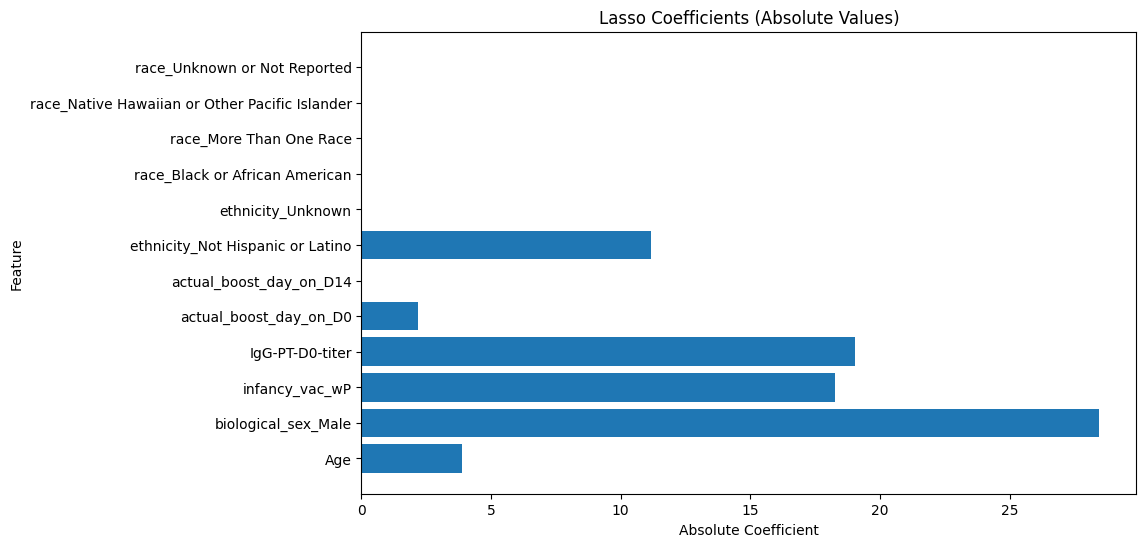

In [14]:
# Use Lasso Regression to select features
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train_scaled, y_train)
lasso_coefficients = lasso_model.coef_
selected_features = X_train_scaled.columns[lasso_coefficients != 0]
X_train_scaled_selected = X_train_scaled[selected_features]
X_test_scaled_selected = X_test_scaled[selected_features]

print("Selected Features:", selected_features)
print("Coefficients:", abs(lasso_coefficients))

plt.figure(figsize=(10, 6))
plt.barh(range(len(X_train_scaled.columns)), abs(lasso_coefficients), align="center")
plt.yticks(range(len(X_train_scaled.columns)), X_train_scaled.columns)
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.title('Lasso Coefficients (Absolute Values)')
plt.show()

Selected Features: Index(['Age', 'biological_sex_Male', 'infancy_vac_wP', 'IgG-PT-D0-titer',
       'actual_boost_day_on_D0', 'ethnicity_Not Hispanic or Latino',
       'race_Black or African American', 'race_More Than One Race',
       'race_Unknown or Not Reported'],
      dtype='object')
Feature Importances: [1.41885425e-01 7.00209136e-02 1.08217115e-01 4.10018117e-01
 6.45707113e-02 6.42305815e-03 1.10859184e-01 4.57377234e-03
 1.65895306e-02 3.30151022e-02 1.88031685e-04 3.36390390e-02]


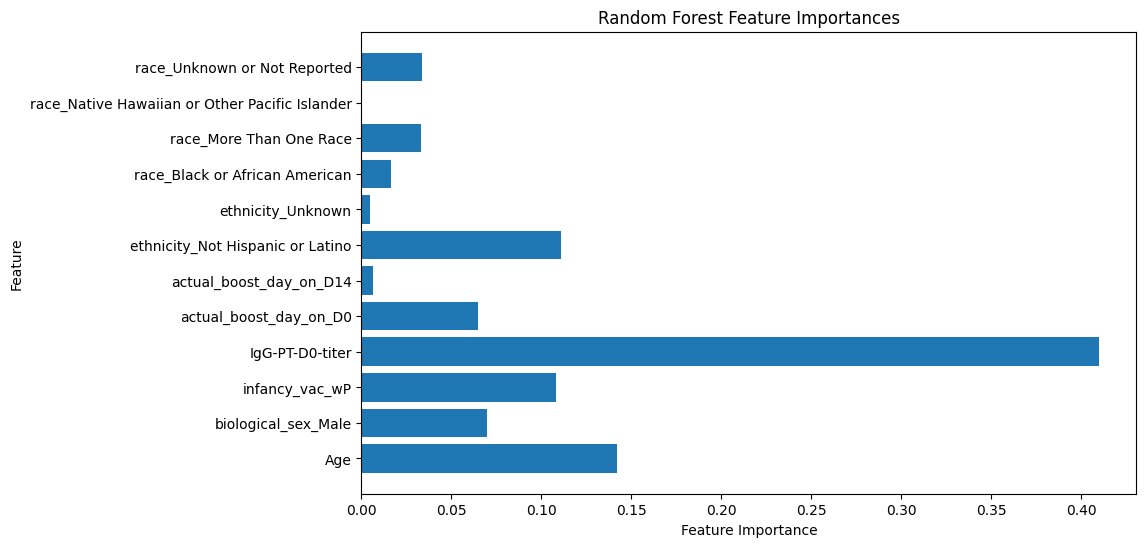

In [15]:
# Use Random Forest Regressor to select features
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)
feature_importances = rf_model.feature_importances_

threshold = 0.015
selected_features = X_train_scaled.columns[feature_importances > threshold]

X_train_scaled_selected = X_train_scaled[selected_features]
X_test_scaled_selected = X_test_scaled[selected_features]

print("Selected Features:", selected_features)
print("Feature Importances:", feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(X_train_scaled.columns)), feature_importances, align="center")
plt.yticks(range(len(X_train_scaled.columns)), X_train_scaled.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()


### Step 2.2: Modeling

In [16]:
# Random Forest Regression
rf_model = RandomForestRegressor()
param_dist_rf = {
    'n_estimators': [20,30,40,50,100,200, 300, 400,500,600,700],
    'max_depth': [10,13,15,17,20,22,25,27,30],
    'min_samples_split': [5, 10, 15,17,18,19,20],
    'min_samples_leaf': [1, 2, 3]
}

# Randomized Search CV for Random Forest
random_search_rf = RandomizedSearchCV(rf_model,
                                      param_distributions=param_dist_rf, 
                                      n_iter=10, 
                                      scoring='r2',  
                                      cv=5, 
                                      random_state=42)
random_search_rf.fit(X_train_scaled_selected, y_train)

# Print best parameters for Random Forest
print("Random Forest - Best Parameters:", random_search_rf.best_params_)

# Evaluate Random Forest on the test set using R-squared
y_pred_rf = random_search_rf.predict(X_test_scaled_selected)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest - R-squared on Test Set:", r2_rf)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled_selected, y_train)

# Evaluate Linear Regression on the test set using R-squared
y_pred_lr = lr_model.predict(X_test_scaled_selected)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression - R-squared on Test Set:", r2_lr)

# Support Vector Regression
svr_model = SVR()
param_dist_svr = {
    'C': [5, 10, 15],
    'kernel': ['linear', 'rbf']
}

# Randomized Search CV for SVR
random_search_svr = RandomizedSearchCV(svr_model, param_distributions=param_dist_svr, n_iter=5, scoring='r2', 
                                       cv=5, random_state=42)
random_search_svr.fit(X_train_scaled_selected, y_train)

# Print best parameters for SVR
print("SVR - Best Parameters:", random_search_svr.best_params_)

# Evaluate SVR on the test set using R-squared
y_pred_svr = random_search_svr.predict(X_test_scaled_selected)
r2_svr = r2_score(y_test, y_pred_svr)
print("SVR - R-squared on Test Set:", r2_svr)

# Gradient Boosting Regression
gb_model = GradientBoostingRegressor()
param_dist_gb = {
    'n_estimators': [35,36,37,38,39,40,41,42,43],
    'learning_rate': [0.001,0.01,0.02,0.03, 0.05, 0.08,0.1,0.2,0.5,1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4,6,8,10,15,20],
    'min_samples_leaf': [1, 2, 3]
}

# Randomized Search CV for Gradient Boosting
random_search_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist_gb, n_iter=10, scoring='r2',  
                                       cv=5, random_state=42)
random_search_gb.fit(X_train_scaled_selected, y_train)

# Print best parameters for Gradient Boosting
print("Gradient Boosting - Best Parameters:", random_search_gb.best_params_)

# Evaluate Gradient Boosting on the test set using R-squared
y_pred_gb = random_search_gb.predict(X_test_scaled_selected)
r2_gb = r2_score(y_test, y_pred_gb)
print("Gradient Boosting - R-squared on Test Set:", r2_gb)

# Lasso Regression
lasso_model = Lasso()
param_dist_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

# Randomized Search CV for Lasso
random_search_lasso = RandomizedSearchCV(lasso_model, param_distributions=param_dist_lasso, n_iter=5, scoring='r2', 
                                         cv=5, random_state=42)
random_search_lasso.fit(X_train_scaled_selected, y_train)

# Print best parameters for Lasso
print("Lasso - Best Parameters:", random_search_lasso.best_params_)

# Evaluate Lasso on the test set using R-squared
y_pred_lasso = random_search_lasso.predict(X_test_scaled_selected)
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso - R-squared on Test Set:", r2_lasso)

# Ridge Regression
ridge_model = Ridge()
param_dist_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

# Randomized Search CV for Ridge
random_search_ridge = RandomizedSearchCV(ridge_model, param_distributions=param_dist_ridge, n_iter=5, scoring='r2', 
                                         cv=5, random_state=42)
random_search_ridge.fit(X_train_scaled_selected, y_train)

# Print best parameters for Ridge
print("Ridge - Best Parameters:", random_search_ridge.best_params_)

# Evaluate Ridge on the test set using R-squared
y_pred_ridge = random_search_ridge.predict(X_test_scaled_selected)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge - R-squared on Test Set:", r2_ridge)

# ElasticNet Regression
elasticnet_model = ElasticNet()
param_dist_elasticnet = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Randomized Search CV for ElasticNet
random_search_elasticnet = RandomizedSearchCV(elasticnet_model, param_distributions=param_dist_elasticnet, n_iter=10, scoring='r2', 
                                               cv=5, random_state=42)
random_search_elasticnet.fit(X_train_scaled_selected, y_train)

# Print best parameters for ElasticNet
print("ElasticNet - Best Parameters:", random_search_elasticnet.best_params_)

# Evaluate ElasticNet on the test set using R-squared
y_pred_elasticnet = random_search_elasticnet.predict(X_test_scaled_selected)
r2_elasticnet = r2_score(y_test, y_pred_elasticnet)
print("ElasticNet - R-squared on Test Set:", r2_elasticnet)

# Decision Tree Regression
dt_model = DecisionTreeRegressor()
param_dist_dt = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10,15,20],
    'min_samples_leaf': [1, 2, 4,6,8,10,15,20,25,30,35]
}

# Randomized Search CV for Decision Tree
random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_dist_dt, n_iter=5, scoring='r2', 
                                      cv=5, random_state=42)
random_search_dt.fit(X_train_scaled_selected, y_train)

# Print best parameters for Decision Tree
print("Decision Tree - Best Parameters:", random_search_dt.best_params_)

# Evaluate Decision Tree on the test set using R-squared
y_pred_dt = random_search_dt.predict(X_test_scaled_selected)
r2_dt = r2_score(y_test, y_pred_dt)
print("Decision Tree - R-squared on Test Set:", r2_dt)

# K-Nearest Neighbors Regression
knn_model = KNeighborsRegressor()
param_dist_knn = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Randomized Search CV for KNN
random_search_knn = RandomizedSearchCV(knn_model, param_distributions=param_dist_knn, n_iter=10, scoring='r2', 
                                        cv=5, random_state=42)
random_search_knn.fit(X_train_scaled_selected, y_train)

# Print best parameters for KNN
print("KNN - Best Parameters:", random_search_knn.best_params_)

# Evaluate KNN on the test set using R-squared
y_pred_knn = random_search_knn.predict(X_test_scaled_selected)
r2_knn = r2_score(y_test, y_pred_knn)
print("KNN - R-squared on Test Set:", r2_knn)

# Compare r2 of different models
r2_dict = {'Random Forest': r2_rf, 'Linear Regression': r2_lr, 'SVR': r2_svr, 'Gradient Boosting': r2_gb,
            'Lasso': r2_lasso, 'Ridge': r2_ridge, 'ElasticNet': r2_elasticnet, 
            'Decision Tree': r2_dt, 'KNN': r2_knn}

# Find the model with the highest r2
best_model_name = max(r2_dict, key=r2_dict.get)
best_model = None

# Select the best model
if best_model_name == 'Random Forest':
    best_model = random_search_rf
elif best_model_name == 'Linear Regression':
    best_model = lr_model
elif best_model_name == 'SVR':
    best_model = random_search_svr
elif best_model_name == 'Gradient Boosting':
    best_model = random_search_gb
elif best_model_name == 'Lasso':
    best_model = random_search_lasso
elif best_model_name == 'Ridge':
    best_model = random_search_ridge
elif best_model_name == 'ElasticNet':
    best_model = random_search_elasticnet
elif best_model_name == 'Decision Tree':
    best_model = random_search_dt
elif best_model_name == 'KNN':
    best_model = random_search_knn

print(f"\nBest Model: {best_model_name} with R-squared: {r2_dict[best_model_name]}")

Random Forest - Best Parameters: {'n_estimators': 400, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_depth': 22}
Random Forest - R-squared on Test Set: 0.17466393002303893
Linear Regression - R-squared on Test Set: 0.09297722929188279
SVR - Best Parameters: {'kernel': 'linear', 'C': 15}
SVR - R-squared on Test Set: 0.013193233016696504
Gradient Boosting - Best Parameters: {'n_estimators': 40, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_depth': 2, 'learning_rate': 0.01}
Gradient Boosting - R-squared on Test Set: 0.08192295969185925
Lasso - Best Parameters: {'alpha': 0.01}
Lasso - R-squared on Test Set: 0.09066837095930647
Ridge - Best Parameters: {'alpha': 0.1}
Ridge - R-squared on Test Set: 0.10781510263952832
ElasticNet - Best Parameters: {'l1_ratio': 0.7, 'alpha': 0.01}
ElasticNet - R-squared on Test Set: 0.0913356302604964
Decision Tree - Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 15, 'max_depth': 30}
Decision Tree - R-squared on Test Set: -0.00240

### Step 2.3: Prediction

In [19]:
# Make prediction
X_new_data_pred = df_pred.drop(columns=['subject_id'])

# Standardize the new input data
X_new_data_scaled_pred = pd.DataFrame(scaler.fit_transform(X_new_data_pred), columns=X_new_data_pred.columns)
X_new_data_scaled_pred = X_new_data_scaled_pred[selected_features.to_list()]

# Use the best model to make predictions
y_pred_new_data_pred = best_model.predict(X_new_data_scaled_pred)
y_pred_new_data_pred

array([ 4.03119622,  6.6551895 , 10.61284857,  9.3740793 ,  7.30170543,
        8.97750736,  8.34109025,  3.95978731,  9.30460267,  7.06118703,
        8.95100299,  3.95138765,  4.01189702,  3.71636235, 10.118064  ,
        8.37709412,  9.61483587,  3.99219254,  8.36714615,  9.23048569,
        7.06118703])

In [20]:
df_pred['IgG-PT-D14-titer'] = y_pred_new_data_pred

# Create a copy of the DataFrame
df_pred_titer = df_pred[['subject_id', 'Age', 'biological_sex_Male', 'infancy_vac_wP', 'IgG-PT-D14-titer']].copy()
df_pred_titer.loc[:, 'Biological Sex at Birth'] = df_pred_titer['biological_sex_Male']
df_pred_titer.loc[:, 'Vaccine Priming Status'] = df_pred_titer['infancy_vac_wP']
df_pred_titer = df_pred_titer[['subject_id','Age','Biological Sex at Birth','Vaccine Priming Status','IgG-PT-D14-titer']]

# Replace values in 'Biological Sex at Birth' column
df_pred_titer['Biological Sex at Birth'] = df_pred_titer['Biological Sex at Birth'].replace({1.0: 'Male', 0.0: 'Female'})

# Replace values in 'Vaccine Priming Status' column
df_pred_titer['Vaccine Priming Status'] = df_pred_titer['Vaccine Priming Status'].replace({1.0: 'wP', 0.0: 'aP'})

# Print the resulting DataFrame
print("Predictions for New Data:")
df_pred_titer

Predictions for New Data:


,subject_id,Age,Biological Sex at Birth,Vaccine Priming Status,IgG-PT-D14-titer
0,114,31,Male,wP,4.031196
1,103,27,Female,wP,6.655189
2,117,27,Female,aP,10.612849
3,98,28,Female,wP,9.374079
4,116,21,Male,aP,7.301705
5,105,27,Female,wP,8.977507
6,97,35,Male,wP,8.341090
7,110,24,Female,aP,3.959787
8,100,20,Female,aP,9.304603
9,102,18,Male,aP,7.061187


In [21]:
# Rank result
df_pred_titer.loc[:, '1.1) IgG-PT-D14-titer-Rank'] = df_pred_titer['IgG-PT-D14-titer'].\
                                                     rank(ascending=False, method='max').astype(int)
df_pred_titer = df_pred_titer.drop(columns=['IgG-PT-D14-titer'])
df_pred_titer = df_pred_titer.sort_values(by='subject_id')

# Remove the index
df_pred_titer = df_pred_titer.reset_index(drop=True)
df_pred_titer

,subject_id,Age,Biological Sex at Birth,Vaccine Priming Status,1.1) IgG-PT-D14-titer-Rank
0,97,35,Male,wP,11
1,98,28,Female,wP,4
2,99,22,Female,aP,3
3,100,20,Female,aP,5
4,101,18,Male,aP,14
5,102,18,Male,aP,14
6,103,27,Female,wP,15
7,104,32,Female,wP,17
8,105,27,Female,wP,7
9,106,25,Female,aP,20


## Step 3: Build Model for Task 1.2 IgG-PT-D14-titer-FC-Rank

### Step 3.1: Data Preparation

Selected Features: Index(['Age', 'biological_sex_Male', 'infancy_vac_wP', 'IgG-PT-D0-titer',
       'actual_boost_day_on_D0', 'actual_boost_day_on_D14',
       'ethnicity_Not Hispanic or Latino', 'race_More Than One Race',
       'race_Unknown or Not Reported'],
      dtype='object')
Feature Importances: [0.07317447 0.03597693 0.04200177 0.66788512 0.05435692 0.01841048
 0.04078936 0.00072709 0.01236365 0.03284426 0.0021834  0.01928654]


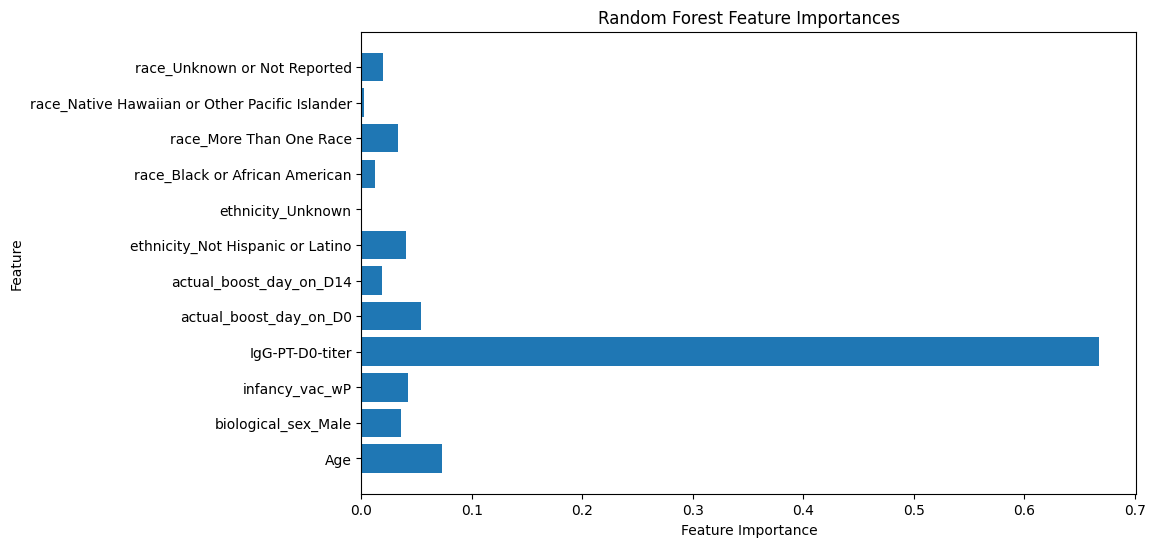

In [22]:
# Split train data and test data
X = df_train.drop(columns=['subject_id', 'IgG-PT-D14-FC','IgG-PT-D14-titer'])
y = df_train['IgG-PT-D14-FC']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

from sklearn.preprocessing import Normalizer
scaler = Normalizer()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Use Random Forest Regressor to select features
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)
feature_importances = rf_model.feature_importances_

threshold = 0.015
selected_features = X_train_scaled.columns[feature_importances > threshold]

X_train_scaled_selected = X_train_scaled[selected_features]
X_test_scaled_selected = X_test_scaled[selected_features]

print("Selected Features:", selected_features)
print("Feature Importances:", feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(X_train_scaled.columns)), feature_importances, align="center")
plt.yticks(range(len(X_train_scaled.columns)), X_train_scaled.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()

### Step 3.2: Modeling

In [23]:
# Random Forest Regression
rf_model = RandomForestRegressor()
param_dist_rf = {
    'n_estimators': [20,30,40,50,100,200, 300, 400,500,600,700],
    'max_depth': [10,13,15,17,20,22,25,27,30],
    'min_samples_split': [5, 10, 15,17,18,19,20],
    'min_samples_leaf': [1, 2, 3]
}

# Randomized Search CV for Random Forest
random_search_rf = RandomizedSearchCV(rf_model,
                                      param_distributions=param_dist_rf, 
                                      n_iter=10, 
                                      scoring='r2',  
                                      cv=5, 
                                      random_state=42)
random_search_rf.fit(X_train_scaled_selected, y_train)

# Print best parameters for Random Forest
print("Random Forest - Best Parameters:", random_search_rf.best_params_)

# Evaluate Random Forest on the test set using R-squared
y_pred_rf = random_search_rf.predict(X_test_scaled_selected)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest - R-squared on Test Set:", r2_rf)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled_selected, y_train)

# Evaluate Linear Regression on the test set using R-squared
y_pred_lr = lr_model.predict(X_test_scaled_selected)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression - R-squared on Test Set:", r2_lr)

# Support Vector Regression
svr_model = SVR()
param_dist_svr = {
    'C': [5, 10, 15],
    'kernel': ['linear', 'rbf']
}

# Randomized Search CV for SVR
random_search_svr = RandomizedSearchCV(svr_model, param_distributions=param_dist_svr, n_iter=5, scoring='r2', 
                                       cv=5, random_state=42)
random_search_svr.fit(X_train_scaled_selected, y_train)

# Print best parameters for SVR
print("SVR - Best Parameters:", random_search_svr.best_params_)

# Evaluate SVR on the test set using R-squared
y_pred_svr = random_search_svr.predict(X_test_scaled_selected)
r2_svr = r2_score(y_test, y_pred_svr)
print("SVR - R-squared on Test Set:", r2_svr)

# Gradient Boosting Regression
gb_model = GradientBoostingRegressor()
param_dist_gb = {
    'n_estimators': [35,36,37,38,39,40,41,42,43],
    'learning_rate': [0.001,0.01,0.02,0.03, 0.05, 0.08,0.1,0.2,0.5,1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4,6,8,10,15,20],
    'min_samples_leaf': [1, 2, 3]
}

# Randomized Search CV for Gradient Boosting
random_search_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist_gb, n_iter=10, scoring='r2',  
                                       cv=5, random_state=42)
random_search_gb.fit(X_train_scaled_selected, y_train)

# Print best parameters for Gradient Boosting
print("Gradient Boosting - Best Parameters:", random_search_gb.best_params_)

# Evaluate Gradient Boosting on the test set using R-squared
y_pred_gb = random_search_gb.predict(X_test_scaled_selected)
r2_gb = r2_score(y_test, y_pred_gb)
print("Gradient Boosting - R-squared on Test Set:", r2_gb)

# Lasso Regression
lasso_model = Lasso()
param_dist_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

# Randomized Search CV for Lasso
random_search_lasso = RandomizedSearchCV(lasso_model, param_distributions=param_dist_lasso, n_iter=5, scoring='r2', 
                                         cv=5, random_state=42)
random_search_lasso.fit(X_train_scaled_selected, y_train)

# Print best parameters for Lasso
print("Lasso - Best Parameters:", random_search_lasso.best_params_)

# Evaluate Lasso on the test set using R-squared
y_pred_lasso = random_search_lasso.predict(X_test_scaled_selected)
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso - R-squared on Test Set:", r2_lasso)

# Ridge Regression
ridge_model = Ridge()
param_dist_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

# Randomized Search CV for Ridge
random_search_ridge = RandomizedSearchCV(ridge_model, param_distributions=param_dist_ridge, n_iter=5, scoring='r2', 
                                         cv=5, random_state=42)
random_search_ridge.fit(X_train_scaled_selected, y_train)

# Print best parameters for Ridge
print("Ridge - Best Parameters:", random_search_ridge.best_params_)

# Evaluate Ridge on the test set using R-squared
y_pred_ridge = random_search_ridge.predict(X_test_scaled_selected)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge - R-squared on Test Set:", r2_ridge)

# ElasticNet Regression
elasticnet_model = ElasticNet()
param_dist_elasticnet = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Randomized Search CV for ElasticNet
random_search_elasticnet = RandomizedSearchCV(elasticnet_model, param_distributions=param_dist_elasticnet, n_iter=10, scoring='r2', 
                                               cv=5, random_state=42)
random_search_elasticnet.fit(X_train_scaled_selected, y_train)

# Print best parameters for ElasticNet
print("ElasticNet - Best Parameters:", random_search_elasticnet.best_params_)

# Evaluate ElasticNet on the test set using R-squared
y_pred_elasticnet = random_search_elasticnet.predict(X_test_scaled_selected)
r2_elasticnet = r2_score(y_test, y_pred_elasticnet)
print("ElasticNet - R-squared on Test Set:", r2_elasticnet)

# Decision Tree Regression
dt_model = DecisionTreeRegressor()
param_dist_dt = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10,15,20],
    'min_samples_leaf': [1, 2, 4,6,8,10,15,20,25,30,35]
}

# Randomized Search CV for Decision Tree
random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_dist_dt, n_iter=5, scoring='r2', 
                                      cv=5, random_state=42)
random_search_dt.fit(X_train_scaled_selected, y_train)

# Print best parameters for Decision Tree
print("Decision Tree - Best Parameters:", random_search_dt.best_params_)

# Evaluate Decision Tree on the test set using R-squared
y_pred_dt = random_search_dt.predict(X_test_scaled_selected)
r2_dt = r2_score(y_test, y_pred_dt)
print("Decision Tree - R-squared on Test Set:", r2_dt)

# K-Nearest Neighbors Regression
knn_model = KNeighborsRegressor()
param_dist_knn = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Randomized Search CV for KNN
random_search_knn = RandomizedSearchCV(knn_model, param_distributions=param_dist_knn, n_iter=10, scoring='r2', 
                                        cv=5, random_state=42)
random_search_knn.fit(X_train_scaled_selected, y_train)

# Print best parameters for KNN
print("KNN - Best Parameters:", random_search_knn.best_params_)

# Evaluate KNN on the test set using R-squared
y_pred_knn = random_search_knn.predict(X_test_scaled_selected)
r2_knn = r2_score(y_test, y_pred_knn)
print("KNN - R-squared on Test Set:", r2_knn)

# Compare r2 of different models
r2_dict = {'Random Forest': r2_rf, 'Linear Regression': r2_lr, 'SVR': r2_svr, 'Gradient Boosting': r2_gb,
            'Lasso': r2_lasso, 'Ridge': r2_ridge, 'ElasticNet': r2_elasticnet, 
            'Decision Tree': r2_dt, 'KNN': r2_knn}

# Find the model with the highest r2
best_model_name = max(r2_dict, key=r2_dict.get)
best_model = None

# Select the best model
if best_model_name == 'Random Forest':
    best_model = random_search_rf
elif best_model_name == 'Linear Regression':
    best_model = lr_model
elif best_model_name == 'SVR':
    best_model = random_search_svr
elif best_model_name == 'Gradient Boosting':
    best_model = random_search_gb
elif best_model_name == 'Lasso':
    best_model = random_search_lasso
elif best_model_name == 'Ridge':
    best_model = random_search_ridge
elif best_model_name == 'ElasticNet':
    best_model = random_search_elasticnet
elif best_model_name == 'Decision Tree':
    best_model = random_search_dt
elif best_model_name == 'KNN':
    best_model = random_search_knn

print(f"\nBest Model: {best_model_name} with R-squared: {r2_dict[best_model_name]}")

Random Forest - Best Parameters: {'n_estimators': 20, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 13}
Random Forest - R-squared on Test Set: 0.4685355645236633
Linear Regression - R-squared on Test Set: 0.17844924423435993
SVR - Best Parameters: {'kernel': 'rbf', 'C': 5}
SVR - R-squared on Test Set: 0.3432754615183907
Gradient Boosting - Best Parameters: {'n_estimators': 40, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_depth': 2, 'learning_rate': 0.01}
Gradient Boosting - R-squared on Test Set: 0.28161762559713444
Lasso - Best Parameters: {'alpha': 0.01}
Lasso - R-squared on Test Set: 0.3127059574171115
Ridge - Best Parameters: {'alpha': 0.1}
Ridge - R-squared on Test Set: 0.3488786378309455
ElasticNet - Best Parameters: {'l1_ratio': 0.7, 'alpha': 0.01}
ElasticNet - R-squared on Test Set: 0.39558761044326496
Decision Tree - Best Parameters: {'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 20}
Decision Tree - R-squared on Test Set: 0.45906379389910

### Step 3.3: Prediction

In [24]:
# Make prediction
X_new_data_pred = df_pred.drop(columns=['subject_id'])

# Standardize the new input data
X_new_data_scaled_pred = pd.DataFrame(scaler.fit_transform(X_new_data_pred), columns=X_new_data_pred.columns)
X_new_data_scaled_pred = X_new_data_scaled_pred[selected_features.to_list()]

# Use the best model to make predictions
y_pred_new_data_pred = best_model.predict(X_new_data_scaled_pred)
y_pred_new_data_pred


array([3.92744588, 2.95978851, 2.82401084, 2.90602304, 1.93795959,
       2.90602304, 2.92072223, 3.21146196, 3.09481346, 1.65750809,
       2.88612241, 3.06657853, 3.1904775 , 3.9635063 , 2.90602304,
       2.37449078, 2.26420129, 2.99161618, 2.77933239, 2.44212285,
       1.77677309])

In [25]:
df_pred['IgG-PT-D14-FC'] = y_pred_new_data_pred

# Create a copy of the DataFrame
df_pred_FC = df_pred[['subject_id', 'Age', 'biological_sex_Male', 'infancy_vac_wP', 'IgG-PT-D14-FC']].copy()
df_pred_FC.loc[:, 'Biological Sex at Birth'] = df_pred_FC['biological_sex_Male']
df_pred_FC.loc[:, 'Vaccine Priming Status'] = df_pred_FC['infancy_vac_wP']
df_pred_FC = df_pred_FC[['subject_id','Age','Biological Sex at Birth','Vaccine Priming Status','IgG-PT-D14-FC']]

# Replace values in 'Biological Sex at Birth' column
df_pred_FC['Biological Sex at Birth'] = df_pred_FC['Biological Sex at Birth'].replace({1.0: 'Male', 0.0: 'Female'})

# Replace values in 'Vaccine Priming Status' column
df_pred_FC['Vaccine Priming Status'] = df_pred_FC['Vaccine Priming Status'].replace({1.0: 'wP', 0.0: 'aP'})

# Print the resulting DataFrame
print("Predictions for New Data:")
df_pred_FC

Predictions for New Data:


,subject_id,Age,Biological Sex at Birth,Vaccine Priming Status,IgG-PT-D14-FC
0,114,31,Male,wP,3.927446
1,103,27,Female,wP,2.959789
2,117,27,Female,aP,2.824011
3,98,28,Female,wP,2.906023
4,116,21,Male,aP,1.937960
5,105,27,Female,wP,2.906023
6,97,35,Male,wP,2.920722
7,110,24,Female,aP,3.211462
8,100,20,Female,aP,3.094813
9,102,18,Male,aP,1.657508


In [26]:
# Rank result
df_pred_FC.loc[:, '1.2) IgG-PT-D14-FC-Rank'] = df_pred_FC['IgG-PT-D14-FC'].\
                                                     rank(ascending=False, method='max').astype(int)
df_pred_FC = df_pred_FC.drop(columns=['IgG-PT-D14-FC'])
df_pred_FC = df_pred_FC.sort_values(by='subject_id')

# Remove the index
df_pred_FC = df_pred_FC.reset_index(drop=True)
df_pred_FC

,subject_id,Age,Biological Sex at Birth,Vaccine Priming Status,1.2) IgG-PT-D14-FC-Rank
0,97,35,Male,wP,9
1,98,28,Female,wP,12
2,99,22,Female,aP,18
3,100,20,Female,aP,5
4,101,18,Male,aP,20
5,102,18,Male,aP,21
6,103,27,Female,wP,8
7,104,32,Female,wP,4
8,105,27,Female,wP,12
9,106,25,Female,aP,6


In [27]:
df_task1 = pd.merge(df_pred_titer, df_pred_FC[['subject_id', '1.2) IgG-PT-D14-FC-Rank']], on='subject_id')

df_task1

,subject_id,Age,Biological Sex at Birth,Vaccine Priming Status,1.1) IgG-PT-D14-titer-Rank,1.2) IgG-PT-D14-FC-Rank
0,97,35,Male,wP,11,9
1,98,28,Female,wP,4,12
2,99,22,Female,aP,3,18
3,100,20,Female,aP,5,5
4,101,18,Male,aP,14,20
5,102,18,Male,aP,14,21
6,103,27,Female,wP,15,8
7,104,32,Female,wP,17,4
8,105,27,Female,wP,7,12
9,106,25,Female,aP,20,6


In [29]:
new_columns = ['2.1) Monocytes-D1-Rank', '2.2) Monocytes-D1-FC-Rank', '3.1) CCL3-D3-Rank', '3.2) CCL3-D3-FC-Rank']
new_data = {column: [None] * len(df_task1) for column in new_columns}
new_df = pd.DataFrame(new_data)
df_task1 = pd.concat([df_task1, new_df], axis=1)

df_task1

,subject_id,Age,Biological Sex at Birth,Vaccine Priming Status,1.1) IgG-PT-D14-titer-Rank,1.2) IgG-PT-D14-FC-Rank,2.1) Monocytes-D1-Rank,2.2) Monocytes-D1-FC-Rank,3.1) CCL3-D3-Rank,3.2) CCL3-D3-FC-Rank
0,97,35,Male,wP,11,9,None,None,None,None
1,98,28,Female,wP,4,12,None,None,None,None
2,99,22,Female,aP,3,18,None,None,None,None
3,100,20,Female,aP,5,5,None,None,None,None
4,101,18,Male,aP,14,20,None,None,None,None
5,102,18,Male,aP,14,21,None,None,None,None
6,103,27,Female,wP,15,8,None,None,None,None
7,104,32,Female,wP,17,4,None,None,None,None
8,105,27,Female,wP,7,12,None,None,None,None
9,106,25,Female,aP,20,6,None,None,None,None


In [30]:
df_task1.to_csv('Task1_peng.tsv', sep='\t', index=False)
print('output to tsv')

output to tsv
